In [44]:
import ase
from util_funcs import AtomsToGraphs
import util_funcs
from torch_geometric.utils import to_networkx, from_networkx
import numpy as np

In [45]:
a2g = AtomsToGraphs(
    max_neigh=50,
    radius=6,
    r_energy=True,
    r_forces=True,
    r_distances=True,
    r_edges=True,
    r_fixed=True,
)
i = 1
loc = "C:/Users/Harshit/PycharmProjects/S2EF/s2ef_train_200K/" + "{}.extxyz".format(i)
raw_data = ase.io.read(loc, ':')
data_0 = raw_data[0]
graph_data = a2g.convert(data_0)

In [46]:
graph_data

Data(pos=[79, 3], cell=[1, 3, 3], atomic_numbers=[79], atomic_masses=[79], natoms=79, edge_index=[2, 3469], cell_offsets=[3469, 3], y=-537.61082559, force=[79, 3], distances=[3469], tags=[79], fixed=[79], x=[79, 3, 3])

# Creating new relational edge-feature to control the message passing from the edges
----
> ## Edge-para (h)
>> It parameterise the edges on the basis of distance from one another; as the forces of neighbouring atom Atom2  far from the Atom1 have  very little influence on Atom1 also vice-versa.
<br> The force influence is inversely propotional to the distances.
<br> f ~ 1/A;   &emsp;  f = forces, A = Distances
<br> f = h/A or h = f*A
<br> for Atom1 --> h1 = avg(forces)* int(disctances)
<br> for Atom2 --> h2 = avg(forces)* int(disctances)
<br> h = (h1 + h2)/2

In [47]:
info =  graph_data.force.numpy()
print("max : {}, min : {}, avg : {}".format(np.max(info), np.min(info), np.average(info)))

max : 1.7899909019470215, min : -1.575884222984314, avg : -2.0119710342214603e-09


In [48]:
dis = graph_data.distances.numpy()
print("max : {} A, min : {} A, avg : {} A".format(np.max(dis), np.min(dis), np.average(dis)))

max : 5.9988274574279785 A, min : 0.964176595211029 A, avg : 4.4172186851501465 A


In [49]:
z = np.zeros((graph_data.num_nodes, graph_data.num_nodes))
for i in range(len(graph_data.distances)):
    z[graph_data.edge_index[0, i],graph_data.edge_index[1, i] ] = graph_data.distances[i]

In [50]:
force_avrg = np.average(info, axis=-1)
f_d = np.diag(force_avrg)
h_ =  f_d@z
h = (h_ + h_.T)*0.5

l = list()
for i in graph_data.edge_index.t():
    l.append(h[i[0], i[1]])

In [51]:
graph_data.edge_attr = l
g_1 = to_networkx(graph_data, node_attrs= ["pos","atomic_numbers", "force", "x" ],
                  edge_attrs= ["edge_attr", "cell_offsets"])

In [52]:
goku = from_networkx(g_1)
goku.y = graph_data.y

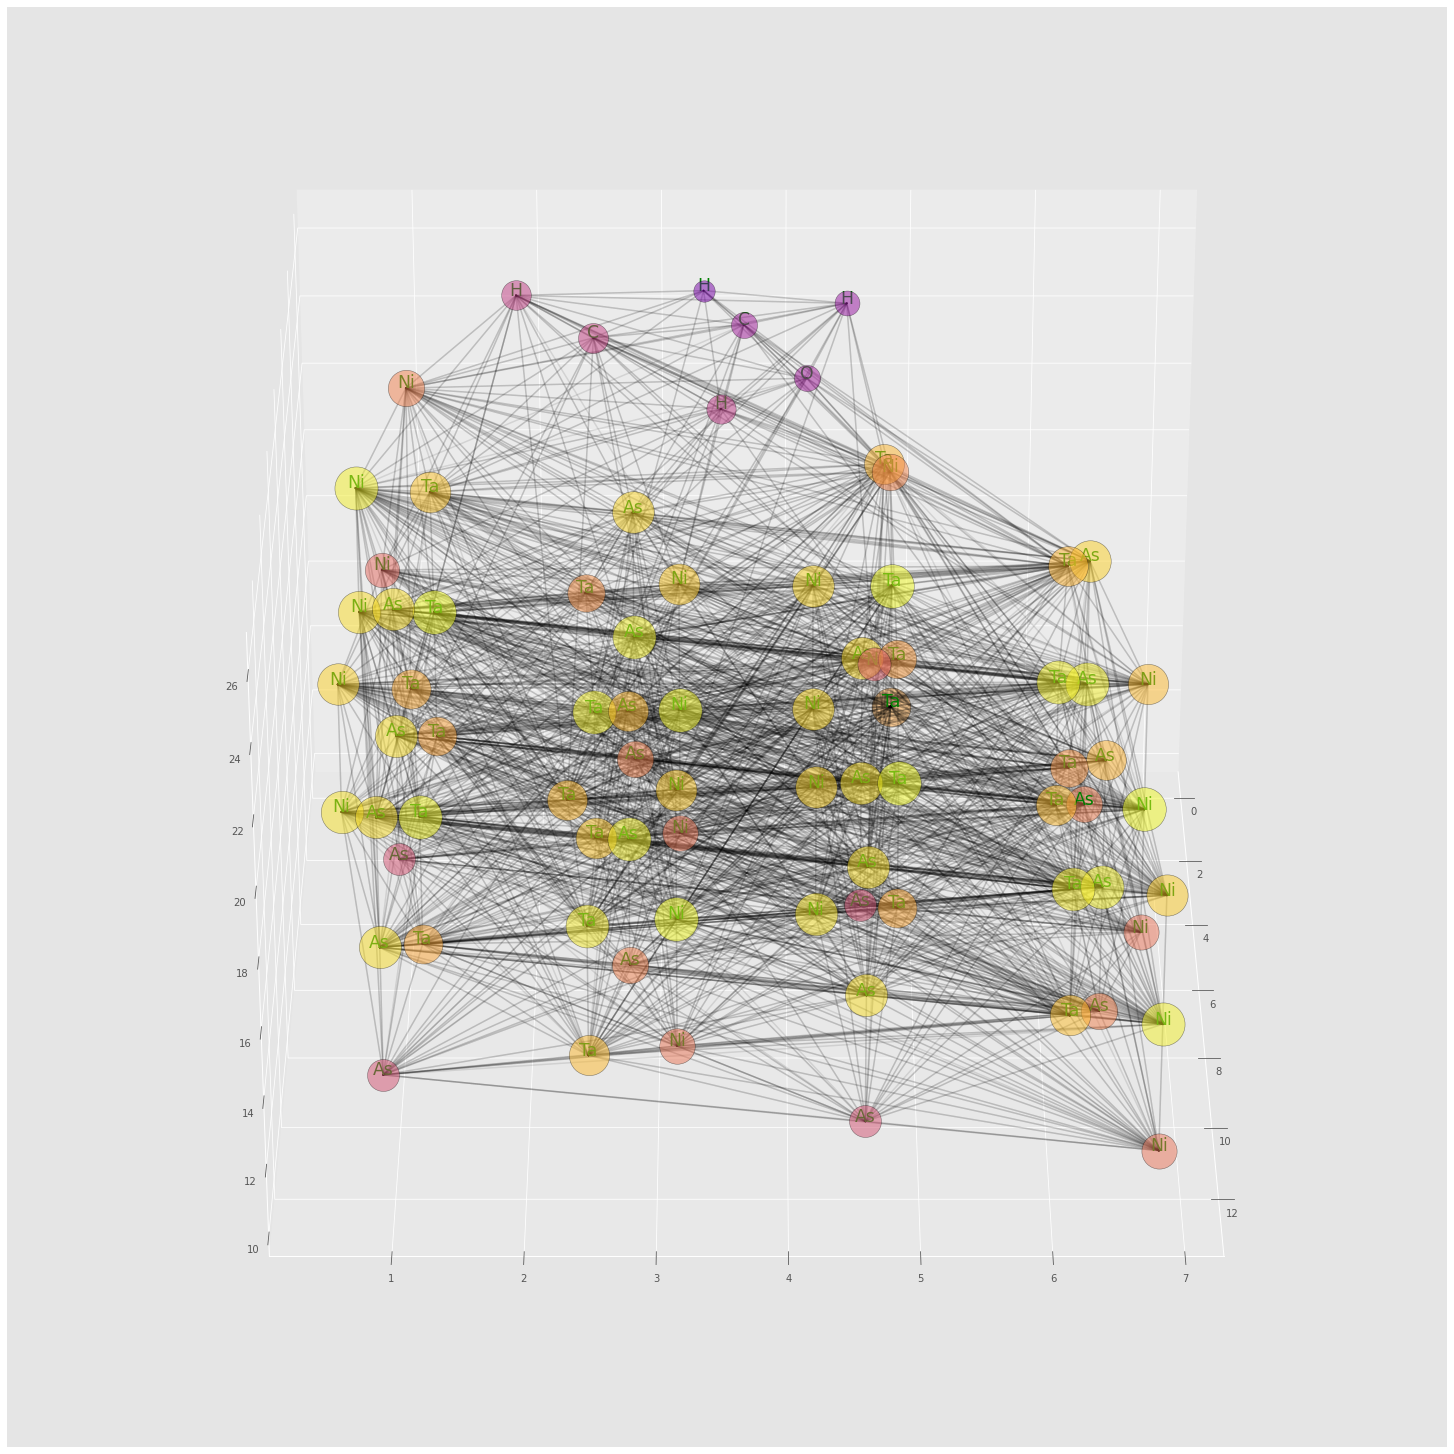

Data(x=[79, 3, 3], edge_index=[2, 2982], edge_attr=[2982], pos=[79, 3], atomic_numbers=[79], force=[79, 3], cell_offsets=[2982, 3], y=-537.61082559)

In [54]:
util_funcs.network_plot_3D(g_1, 0, save=False)
goku